In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [30]:
from simulation.gen_pend import *

param_dists = {
    'q': stats.uniform(-np.pi, 2 * np.pi),
    'v': stats.uniform(-6., 12),
    'b': stats.uniform(0., .2)
}

times, trajs = gen_trajs(50_000, 2., 20, param_dists)

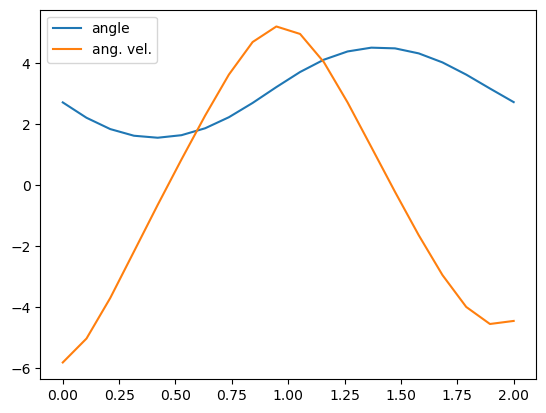

In [31]:
# plot a random trajectory
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

Since Pinocchio doesn't give the angles mod 2pi, the angular measurements could get very large. We'll stick to short time-frames so that this doesn't become a problem.

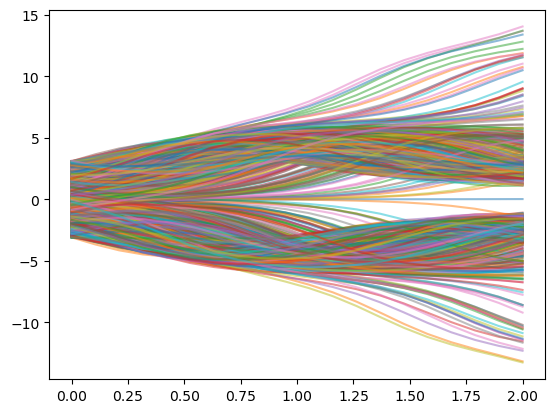

In [32]:
for i in range(1000):
    plt.plot(times, trajs[i, 0], alpha=.5)

## Splitting the trajectories into windows


In [29]:
class TrajWindowsDataset(Dataset):
    def __init__(self, trajs, window):
        super().__init__()
        self.window = window
        self.n_simulations, _, self.n_steps = trajs.shape
        assert window <= self.n_steps
        self.windows_per_traj = self.n_steps - self.window + 1

    def __len__(self):
        return self.n_simulations * self.windows_per_traj

    def __getitem__(self, idx):
        i = idx // self.windows_per_traj
        j = idx % self.windows_per_traj
        return trajs[i, :, j:(j+self.window)]

In [358]:
window = 20
X = TrajWindowsDataset(trajs, window)
dl = DataLoader(X, batch_size=256, shuffle=True)

## MLP

In [34]:
X_tr, X_val = random_split(torch.tensor(trajs), (30_000, 20_000))
dl_tr = DataLoader(X_tr, batch_size=256, shuffle=True)
dl_val = DataLoader(X_val, batch_size=256, shuffle=True)

In [35]:
class TrajEnc(nn.Module):

    def __init__(self, window, n_features, latent_dim):
        super(TrajEnc, self).__init__()

        self.window = window
        self.n_features = n_features

        self.enc = nn.Sequential(
            nn.Linear(window * n_features, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, window * n_features),
        )

    def forward(self, x):
        # x: (bs, n_features, window)
        x = torch.flatten(x, start_dim=1) # x: (bs, n_features * window)
        u = self.enc(x)
        rec = torch.unflatten(self.dec(u), dim=1, sizes=(self.n_features, self.window))
        return rec, u

In [71]:
te = TrajEnc(20, 2, 2)

opt = optim.Adam(te.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in te.parameters())}')

# params: 2050


In [72]:
n_epochs = 500

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # --- Training ---
    te.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dl_tr):
        opt.zero_grad()
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        loss.backward()
        opt.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(dl_tr.dataset)
    train_losses.append(train_loss)

    # --- Validation ---
    te.eval()
    val_loss = 0.0

    for batch_idx, x in enumerate(dl_val):
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(dl_val.dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Tr Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

Epoch [10/500], Tr Loss: 163.1002 Val Loss: 108.1025
Epoch [20/500], Tr Loss: 127.9522 Val Loss: 86.9777
Epoch [30/500], Tr Loss: 85.3279 Val Loss: 56.5032
Epoch [40/500], Tr Loss: 64.3842 Val Loss: 43.3219
Epoch [50/500], Tr Loss: 56.5248 Val Loss: 37.9243
Epoch [60/500], Tr Loss: 52.6518 Val Loss: 35.6931
Epoch [70/500], Tr Loss: 49.0398 Val Loss: 32.7854
Epoch [80/500], Tr Loss: 47.2120 Val Loss: 31.4103
Epoch [90/500], Tr Loss: 45.3025 Val Loss: 30.3364
Epoch [100/500], Tr Loss: 43.8662 Val Loss: 30.2497
Epoch [110/500], Tr Loss: 43.1905 Val Loss: 28.9027
Epoch [120/500], Tr Loss: 41.3953 Val Loss: 27.8617
Epoch [130/500], Tr Loss: 39.8908 Val Loss: 26.4861
Epoch [140/500], Tr Loss: 38.2449 Val Loss: 25.2477
Epoch [150/500], Tr Loss: 37.3026 Val Loss: 25.5046
Epoch [160/500], Tr Loss: 36.9294 Val Loss: 23.9237
Epoch [170/500], Tr Loss: 35.8360 Val Loss: 24.9086
Epoch [180/500], Tr Loss: 35.0137 Val Loss: 23.5793
Epoch [190/500], Tr Loss: 34.5542 Val Loss: 22.6194
Epoch [200/500], T

In [77]:
PATH = './mlp.pth'
torch.save(te, PATH)

In [ ]:
PATH = './mlp.pth'
te = torch.load(PATH)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.TrajEnc was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.TrajEnc])` or the `torch.serialization.safe_globals([__main__.TrajEnc])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

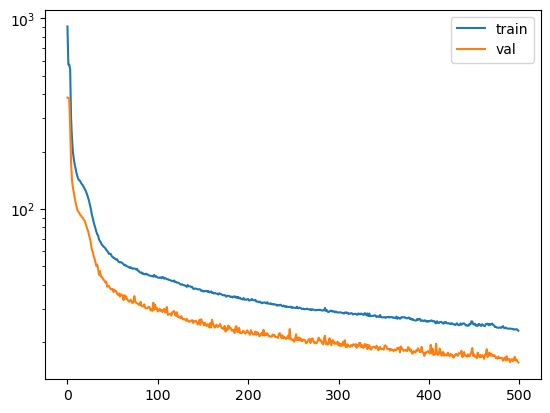

In [73]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.legend()

In [74]:
with torch.no_grad():
    _, latents = te(torch.tensor(trajs))

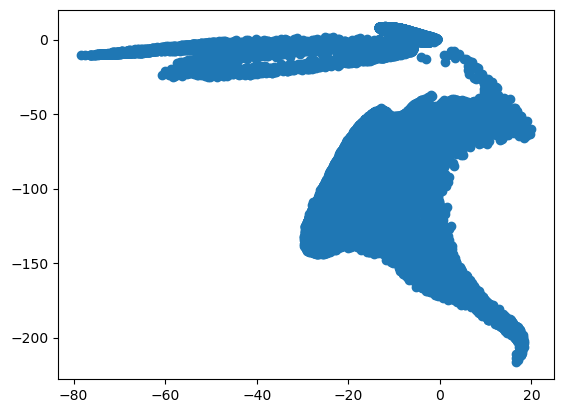

In [75]:
plt.scatter(*latents.T)

In [81]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(times, trajs[idx, 0, :], alpha=.3)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_14109/4048237539.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(latents - pt, axis=1)


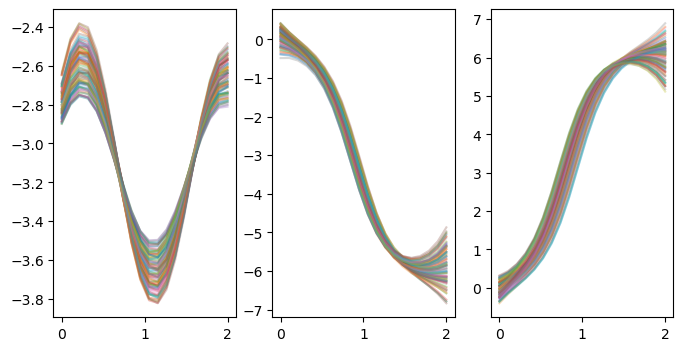

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
plot_most_similar(latents, np.array([0, -20]), 100, axs[0])
plot_most_similar(latents, np.array([15, -20]), 100, axs[1])
plot_most_similar(latents, np.array([20, 20]), 100, axs[2])

In [50]:
from latent_app import create_dash_app

In [51]:
app = create_dash_app(latents.numpy()[::2], trajs[::2, 0])
app.run()

## Testing trajectories outside of the training distribution

In [52]:
_, traj_ood = gen_one_traj(2., 20, np.pi/4, 10., 1.)
traj_ood = traj_ood.reshape(1, 2, -1)  # Reshape to match the input shape of the model

with torch.no_grad():
    _, latents_ood = te(torch.tensor(traj_ood))
latents_ood

tensor([[ 11.5051, -34.8920]])

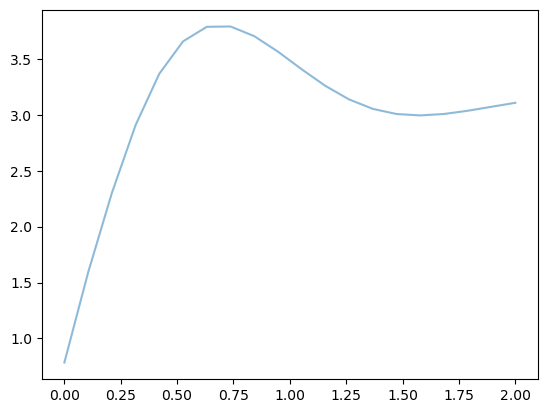

In [53]:
plt.plot(times, traj_ood[0, 0], alpha=.5)

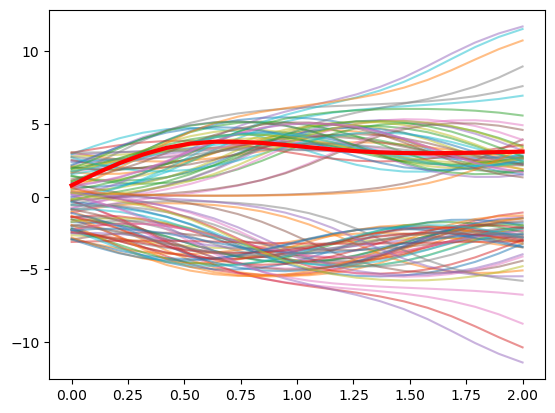

In [54]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, traj_ood[0, 0], color='red', lw=3)

## Using CD poly

In [55]:
from cd_poly.cd_poly import *

In [68]:
p = CDPolynomial(latents, degree=8)
alpha = p(latents).max()

In [69]:
alpha

np.float64(9581.238158578082)

Note: a cutoff significantly less than the max value on the datapoints seems better at capturing the shape of the support.

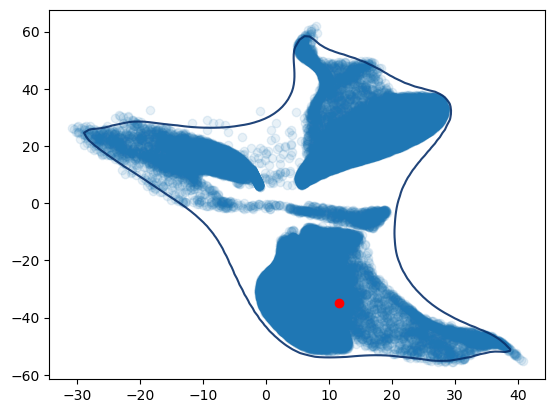

In [70]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T, alpha=0.1)
ax.scatter(*latents_ood.T, color='red')
plot_level_set(p, alpha / 10, ax)

## Testing custom trajectories

Let's create a custom trajectory that couldn't be generated by the simulation with our distribution of parameters.

In [101]:
amp = 1.5
freq = 13.
const = 4
custom = np.array([amp * np.sin(freq * times) + const * times, amp * freq * np.cos(freq * times) + const])

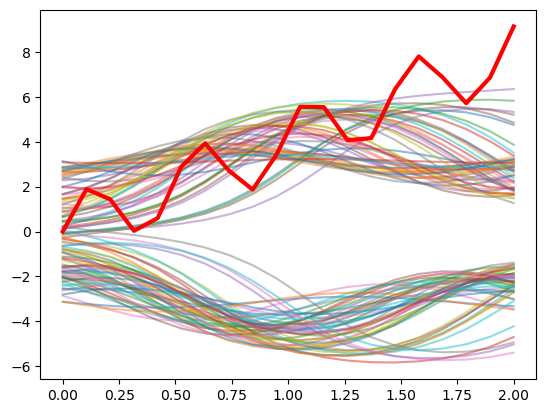

In [102]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, custom[0], color='red', lw=3)

In [103]:
with torch.no_grad():
    _, latents_custom = te(torch.tensor(custom.reshape(1, 2, -1)))
latents_custom

tensor([[25.4982, 23.7022]])

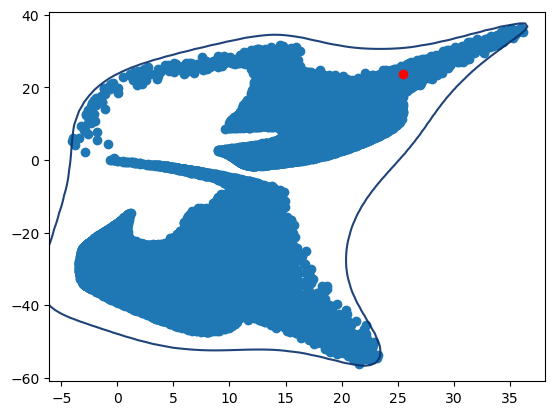

In [104]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_custom.T, color='red')
plot_level_set(p, alpha, ax)